# Setup
Some simple setup for getting the data analysis set up.

In [60]:
import glob, math, os
import multiprocessing as mp
from functools import partial
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook as tqdm

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

DATA_DIR = os.path.join('.', 'data', 'train')
NUM_CPUS = 8

# Dimension Histogram
Generates a histogram of the dimensions of images in the dataset. Since getting image dimensions is utlimately an IO operation involving PIL, multiprocessing is used to speed up the IO-bound nature of this computation.

In [61]:
def count_dims_worker(widths, heights, filenames, pid):
  print("Starting process {}".format(pid))  # To force tqdm progress bars to show up
  local_widths = []
  local_heights = []
  for filename in tqdm(filenames, total=len(filenames), desc="PID {}".format(pid), position=pid):
    im = Image.open(filename)
    width, height = im.size
    local_widths.append(width)
    local_heights.append(height)
  widths += local_widths
  heights += local_heights

def count_dims():
  filenames = list(glob.glob(os.path.join(DATA_DIR, '*.jpg')))
  files_per_proc = math.ceil(len(filenames) / NUM_CPUS)
  with mp.Manager() as manager:
    widths = manager.list()
    heights = manager.list()
    jobs = []
    for i in range(NUM_CPUS):
      p = mp.Process(target=count_dims_worker,
                     args=(widths, heights, filenames[i*files_per_proc:(i+1)*files_per_proc], i))
      jobs.append(p)
      p.start()
    for proc in jobs:
      proc.join()
    
    # Convert from ListProxy object to list.
    widths = widths[0: len(widths)]
    heights = heights[0: len(heights)]
    return widths, heights

widths, heights = count_dims()

Starting process 0
Starting process 1


HBox(children=(IntProgress(value=0, description='PID 0', max=152093), HTML(value='')))

HBox(children=(IntProgress(value=0, description='PID 1', max=152093), HTML(value='')))

Starting process 2


HBox(children=(IntProgress(value=0, description='PID 2', max=152093), HTML(value='')))

Starting process 3
Starting process 4


HBox(children=(IntProgress(value=0, description='PID 3', max=152093), HTML(value='')))

Starting process 5


HBox(children=(IntProgress(value=0, description='PID 4', max=152093), HTML(value='')))

Starting process 6
Starting process 7


HBox(children=(IntProgress(value=0, description='PID 5', max=152093), HTML(value='')))

HBox(children=(IntProgress(value=0, description='PID 6', max=152093), HTML(value='')))

HBox(children=(IntProgress(value=0, description='PID 7', max=152092), HTML(value='')))

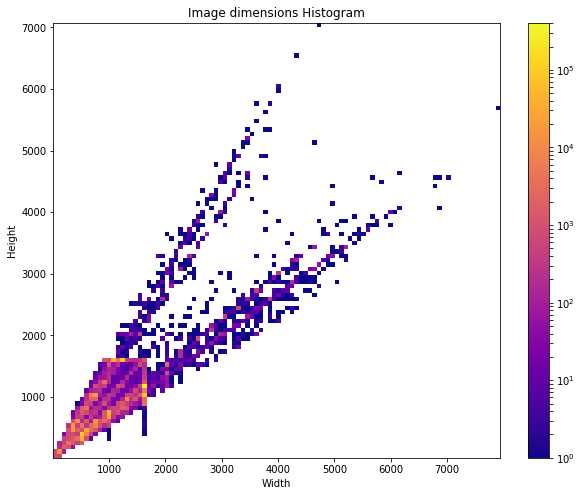

In [64]:
# Plot style inspiration from https://matplotlib.org/examples/pylab_examples/hist2d_log_demo.html
from matplotlib.colors import LogNorm
    
def plot_dims_hist(widths, heights):
  plt.subplot(1, 1, 1)
  plt.title('Image dimensions Histogram')
  plt.hist2d(widths, heights, bins=100, norm=LogNorm(), cmap='plasma')
  plt.xlabel('Width')
  plt.ylabel('Height')
  plt.colorbar()
  plt.show()

plot_dims_hist(widths, heights)

# Occurrence Histogram
Generates a histogram with the number of landmarks with a certain number of images in the dataset. Also identifies the top N landmarks and visualizes them.

In [104]:
from collections import Counter
ims_per_id = Counter()
for i, filename in enumerate(glob.glob(os.path.join(DATA_DIR, '*.jpg'))):
    landmark_id = os.path.splitext(os.path.basename(filename))[0].split('-')[1]
    ims_per_id[landmark_id] += 1

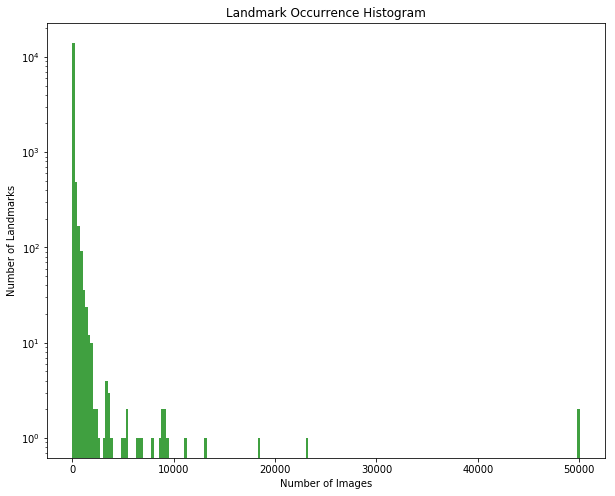

In [105]:
def plot_occurrence_hist(occurrences):
  plt.subplot(1, 1, 1)
  plt.title('Landmark Occurrence Histogram')
  plt.hist(occurrences, 200, log=True, facecolor='g', alpha=0.75)
  plt.xlabel('Number of Images')
  plt.ylabel('Number of Landmarks')
  plt.show()

plot_occurrence_hist(ims_per_id.values())

Printing the top 10 most frequent landmarks:
Landmark #9633 has 50050 images.


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Landmark #6051 has 49855 images.
Landmark #6599 has 23239 images.
Landmark #9779 has 18325 images.
Landmark #2061 has 13198 images.
Landmark #5554 has 11041 images.
Landmark #6651 has 9453 images.
Landmark #6696 has 9169 images.
Landmark #5376 has 9161 images.
Landmark #2743 has 8952 images.


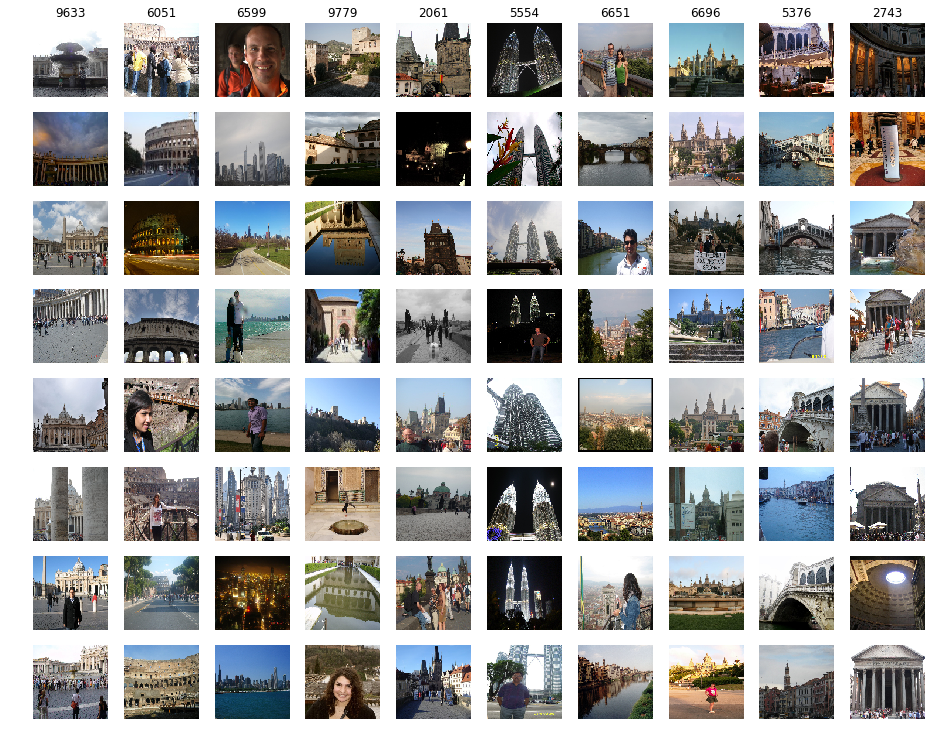

In [106]:
import random
import matplotlib.image as mpimg
from skimage.transform import resize

def get_top_landmarks(occurrences, n):
  occurrences = sorted(occurrences.items(), key=lambda x: x[1], reverse=True)
  return occurrences[:n]

examples_per_landmark = 8
num_landmarks = 10
plt.figure(figsize=(16.0, 12.8))
print("Printing the top 10 most frequent landmarks:")
for i, pair in enumerate(get_top_landmarks(ims_per_id, num_landmarks)):
  landmark, num = pair
  print("Landmark #{} has {} images.".format(landmark, num))
  filenames = glob.glob(os.path.join(DATA_DIR, '*-{}.jpg'.format(landmark)))
  filenames = random.sample(filenames, examples_per_landmark)
  for j in range(examples_per_landmark):
      plt.subplot(examples_per_landmark, num_landmarks, j * num_landmarks + i + 1)
      img = mpimg.imread(filenames[j])
      img = resize(img, (128, 128))
      plt.imshow(img)
      plt.axis('off')
      if j == 0:
          plt.title(landmark)
plt.show()